# ÏàòÏàòÎ£å 

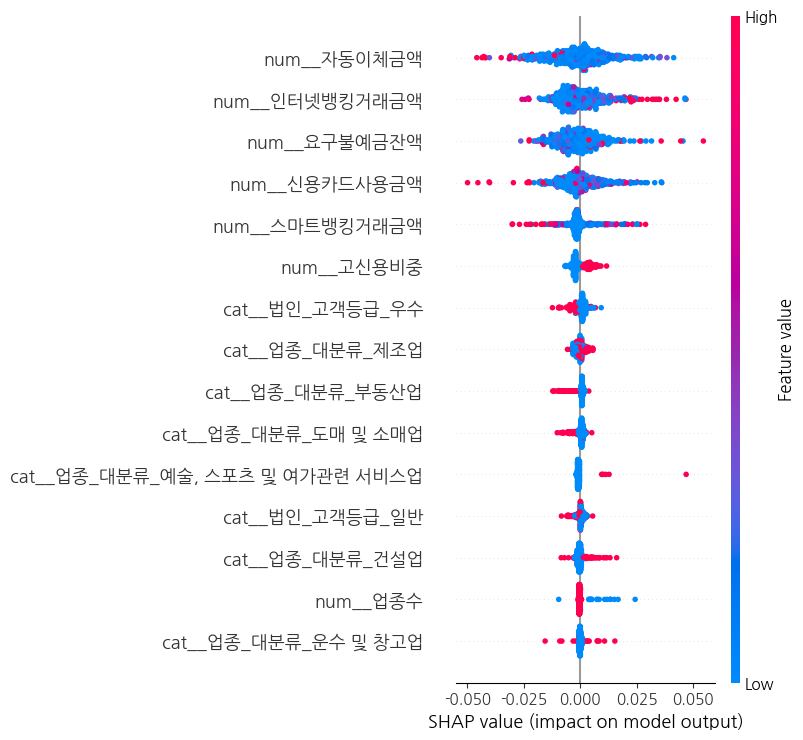

In [5]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

# -----------------------------
# 1. ÏàòÏàòÎ£å ÏàòÏùµ ÌÉÄÍπÉ Î°úÎî©
# -----------------------------
fisis = pd.read_excel("Data/ÏµúÏ¢Ö ÌîÑÎ°úÏ†ùÌä∏/FISIS_MultipleTable_200003-202503.xlsx")

fee_target_df = (
    fisis[(fisis["ÌöåÏÇ¨Î™Ö"] == "ÏïÑÏù¥Ïó†Î±ÖÌÅ¨") & (fisis["Ìï≠Î™©"] == "ÏàòÏàòÎ£åÏàòÏùµ:ÎãπÎ∂ÑÍ∏∞")]
    .drop(columns=["ÌöåÏÇ¨Î™Ö", "ÌöåÏÇ¨ÏΩîÎìú", "Î≥¥Í≥†ÏÑúÎ™Ö", "Î≥¥Í≥†ÏÑúÏΩîÎìú", "Ìï≠Î™©", "factor_id", "Îã®ÏúÑ"])
    .T.rename(columns={fisis[(fisis["ÌöåÏÇ¨Î™Ö"] == "ÏïÑÏù¥Ïó†Î±ÖÌÅ¨") & (fisis["Ìï≠Î™©"] == "ÏàòÏàòÎ£åÏàòÏùµ:ÎãπÎ∂ÑÍ∏∞")].index[0]: "ÏàòÏàòÎ£åÏàòÏùµ"})
)
fee_target_df.index = pd.to_datetime(fee_target_df.index, format="%YÎÖÑ%mÏõî")
fee_target_df = fee_target_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "Í∏∞Ï§ÄÎÖÑÏõî"})


# -----------------------------
# 2. ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ Î°úÎî© Î∞è Î≥ëÌï©
# -----------------------------
df = pd.read_csv("Data/ÏµúÏ¢Ö ÌîÑÎ°úÏ†ùÌä∏/ÏµúÏ¢Ö_Îç∞Ïù¥ÌÑ∞.csv", encoding="cp949")
df["Í∏∞Ï§ÄÎÖÑÏõî"] = pd.to_datetime(df["Í∏∞Ï§ÄÎÖÑÏõî"], format="%Y%m")

merged = pd.merge(df, fee_target_df, on="Í∏∞Ï§ÄÎÖÑÏõî", how="inner").dropna(subset=["ÏàòÏàòÎ£åÏàòÏùµ"])
merged["Í≥†Í∞ùÏàò"] = merged.groupby("Í∏∞Ï§ÄÎÖÑÏõî")["Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â"].transform("count")
merged = merged[merged["Í≥†Í∞ùÏàò"] > 0]

# -----------------------------
# 3. ÌÉÄÍπÉ Î∞è ÌååÏÉù Î≥ÄÏàò ÏÉùÏÑ±
# -----------------------------
merged["ÏàòÏàòÎ£å_perÍ≥†Í∞ù"] = merged["ÏàòÏàòÎ£åÏàòÏùµ"] / merged["Í≥†Í∞ùÏàò"]
y = np.log1p(merged["ÏàòÏàòÎ£å_perÍ≥†Í∞ù"])

merged["Í≥†Ïã†Ïö©ÎπÑÏ§ë"] = (merged["Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â"] == "ÏµúÏö∞Ïàò").astype(int)
merged["ÏóÖÏ¢ÖÏàò"] = merged.groupby("Í∏∞Ï§ÄÎÖÑÏõî")["ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò"].transform("nunique")

# -----------------------------
# 4. ÏÑ§Î™ÖÎ≥ÄÏàò ÏÑ†ÌÉù
# -----------------------------
features = [
    "ÏöîÍµ¨Î∂àÏòàÍ∏àÏûîÏï°", "ÏûêÎèôÏù¥Ï≤¥Í∏àÏï°", "Ïä§ÎßàÌä∏Î±ÖÌÇπÍ±∞ÎûòÍ∏àÏï°",
    "Ïù∏ÌÑ∞ÎÑ∑Î±ÖÌÇπÍ±∞ÎûòÍ∏àÏï°", "Ïã†Ïö©Ïπ¥ÎìúÏÇ¨Ïö©Í∏àÏï°", "Í≥†Ïã†Ïö©ÎπÑÏ§ë", "ÏóÖÏ¢ÖÏàò",
    "Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â", "ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò"
]
X = merged[features]

# -----------------------------
# 5. ÏÉòÌîåÎßÅ Î∞è Ï†ÑÏ≤òÎ¶¨
# -----------------------------
X_sample = X.sample(n=500, random_state=42)
y_sample = y.loc[X_sample.index]

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# -----------------------------
# 6. XGBoost Î™®Îç∏ ÌïôÏäµ
# -----------------------------
xgb_model = XGBRegressor(n_estimators=100, max_depth=4, random_state=42)
pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", xgb_model)
])
pipeline.fit(X_sample, y_sample)

# -----------------------------
# 7. SHAP Í∞í Í≥ÑÏÇ∞ Î∞è ÏãúÍ∞ÅÌôî
# -----------------------------
X_transformed = preprocessor.transform(X_sample)

explainer = shap.Explainer(
    pipeline.named_steps["model"],
    X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    algorithm="tree"
)
shap_values = explainer(X_transformed)

# ÏöîÏïΩ ÏãúÍ∞ÅÌôî (summary_plot)
shap.summary_plot(
    shap_values.values,
    features=X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    plot_type="dot",  # ÎòêÎäî "dot"
    max_display=15
)

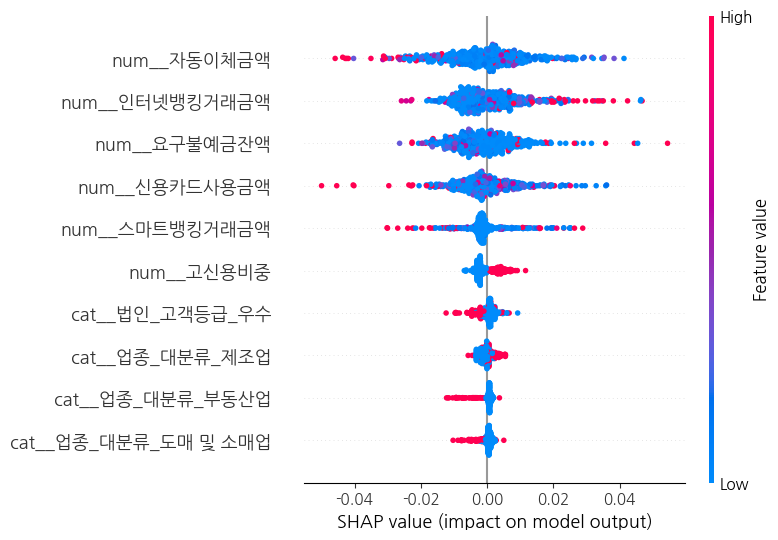

In [4]:
# ÏöîÏïΩ ÏãúÍ∞ÅÌôî (summary_plot)
shap.summary_plot(
    shap_values.values,
    features=X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    plot_type="dot",  # ÎòêÎäî "dot"
    max_display=10
)

# Ïã†ÌÉÅ

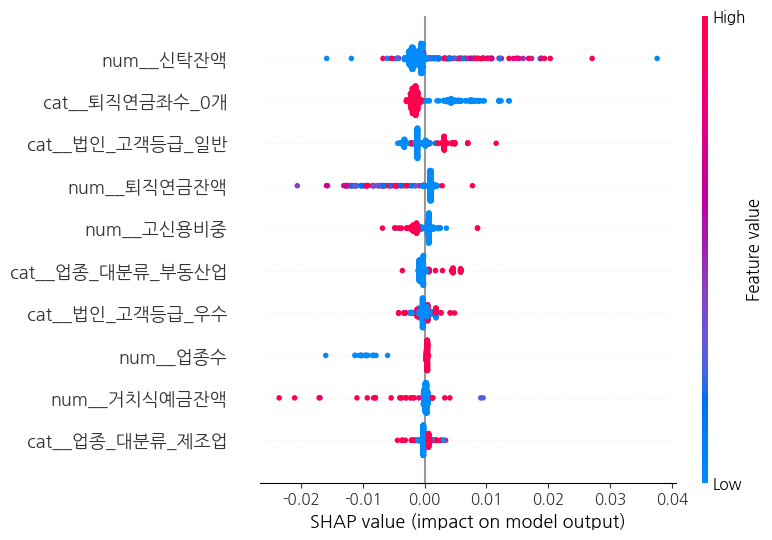

In [6]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

# -----------------------------
# 1. Ïã†ÌÉÅ ÏàòÏùµ ÌÉÄÍπÉ Î°úÎî©
# -----------------------------
fisis = pd.read_excel("Data/ÏµúÏ¢Ö ÌîÑÎ°úÏ†ùÌä∏/FISIS_MultipleTable_200003-202503.xlsx")
trust_target_df = (
    fisis[(fisis["ÌöåÏÇ¨Î™Ö"] == "ÏïÑÏù¥Ïó†Î±ÖÌÅ¨") & (fisis["Ìï≠Î™©"] == "Ïã†ÌÉÅ(ÏùÄÌñâÍ≥ÑÏ†ï) Í¥ÄÎ†® ÏÜêÏùµ:ÎãπÎ∂ÑÍ∏∞")]
    .drop(columns=["ÌöåÏÇ¨Î™Ö", "ÌöåÏÇ¨ÏΩîÎìú", "Î≥¥Í≥†ÏÑúÎ™Ö", "Î≥¥Í≥†ÏÑúÏΩîÎìú", "Ìï≠Î™©", "factor_id", "Îã®ÏúÑ"])
    .T.rename(columns={fisis[(fisis["ÌöåÏÇ¨Î™Ö"] == "ÏïÑÏù¥Ïó†Î±ÖÌÅ¨") & (fisis["Ìï≠Î™©"] == "Ïã†ÌÉÅ(ÏùÄÌñâÍ≥ÑÏ†ï) Í¥ÄÎ†® ÏÜêÏùµ:ÎãπÎ∂ÑÍ∏∞")].index[0]: "Ïã†ÌÉÅÏàòÏùµ"})
)
trust_target_df.index = pd.to_datetime(trust_target_df.index, format="%YÎÖÑ%mÏõî")
trust_target_df = trust_target_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "Í∏∞Ï§ÄÎÖÑÏõî"})

# -----------------------------
# 2. ÎÇ¥Î∂Ä Îç∞Ïù¥ÌÑ∞ Î≥ëÌï© Î∞è ÌÉÄÍπÉ
# -----------------------------
df = pd.read_csv("Data/ÏµúÏ¢Ö ÌîÑÎ°úÏ†ùÌä∏/ÏµúÏ¢Ö_Îç∞Ïù¥ÌÑ∞.csv", encoding="cp949")
df["Í∏∞Ï§ÄÎÖÑÏõî"] = pd.to_datetime(df["Í∏∞Ï§ÄÎÖÑÏõî"], format="%Y%m")
merged = pd.merge(df, trust_target_df, on="Í∏∞Ï§ÄÎÖÑÏõî", how="inner").dropna(subset=["Ïã†ÌÉÅÏàòÏùµ"])
merged["Í≥†Í∞ùÏàò"] = merged.groupby("Í∏∞Ï§ÄÎÖÑÏõî")["Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â"].transform("count")
merged = merged[merged["Í≥†Í∞ùÏàò"] > 0]
merged["Ïã†ÌÉÅ_perÍ≥†Í∞ù"] = merged["Ïã†ÌÉÅÏàòÏùµ"] / merged["Í≥†Í∞ùÏàò"]
y = np.log1p(merged["Ïã†ÌÉÅ_perÍ≥†Í∞ù"])

# -----------------------------
# 3. ÏÑ§Î™ÖÎ≥ÄÏàò Ï†ïÏùò
# -----------------------------
merged["Í≥†Ïã†Ïö©ÎπÑÏ§ë"] = (merged["Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â"] == "ÏµúÏö∞Ïàò").astype(int)
merged["ÏóÖÏ¢ÖÏàò"] = merged.groupby("Í∏∞Ï§ÄÎÖÑÏõî")["ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò"].transform("nunique")

features = [
    "Ïã†ÌÉÅÏûîÏï°", "Ìá¥ÏßÅÏó∞Í∏àÏûîÏï°", "ÏàòÏùµÏ¶ùÍ∂åÏûîÏï°", "Í±∞ÏπòÏãùÏòàÍ∏àÏûîÏï°",
    "Ìá¥ÏßÅÏó∞Í∏àÏ¢åÏàò", "Í≥†Ïã†Ïö©ÎπÑÏ§ë", "ÏóÖÏ¢ÖÏàò",
    "Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â", "ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò"
]
X = merged[features]

# -----------------------------
# 4. Ï†ÑÏ≤òÎ¶¨ + ÏÉòÌîåÎßÅ
# -----------------------------
X_sample = X.sample(n=500, random_state=42)
y_sample = y.loc[X_sample.index]

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

# -----------------------------
# 5. XGBoost ÌïôÏäµ Î∞è SHAP Í≥ÑÏÇ∞
# -----------------------------
xgb_model = XGBRegressor(n_estimators=100, max_depth=4, random_state=42)
pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", xgb_model)
])
pipeline.fit(X_sample, y_sample)

X_transformed = preprocessor.transform(X_sample)
feature_names = preprocessor.get_feature_names_out()

explainer = shap.Explainer(pipeline.named_steps["model"], X_transformed, 
                           feature_names=feature_names, algorithm="tree")
shap_values = explainer(X_transformed)

# -----------------------------
# 6. SHAP Top10 Î≥ÄÏàò ÏãúÍ∞ÅÌôî (dot plot)
# -----------------------------
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    "Î≥ÄÏàò": feature_names,
    "SHAP ÏòÅÌñ•Î†•": mean_abs_shap
}).sort_values(by="SHAP ÏòÅÌñ•Î†•", ascending=False)

top10_features = shap_df["Î≥ÄÏàò"].head(10).tolist()
top10_indices = [i for i, name in enumerate(feature_names) if name in top10_features]

shap.summary_plot(
    shap_values.values[:, top10_indices],
    features=X_transformed[:, top10_indices],
    feature_names=[feature_names[i] for i in top10_indices],
    plot_type="dot"
)

# Ïú†Í∞ÄÏ¶ùÍ∂å Î∞è Ïô∏ÌôòÎ∂ÄÎ¨∏


‚ñ∂ Î™®Îç∏: XGBoost
                        Î≥ÄÏàò  SHAP ÏòÅÌñ•Î†•
4                 num__ÏóÖÏ¢ÖÏàò  0.068585
5          cat__ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò_Í±¥ÏÑ§ÏóÖ  0.030282
3               num__Í≥†Ïã†Ïö©ÎπÑÏ§ë  0.016745
36         cat__Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â_ÏùºÎ∞ò  0.014263
35         cat__Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â_Ïö∞Ïàò  0.012803
2              num__ÏàòÏùµÏ¶ùÍ∂åÏûîÏï°  0.011000
21         cat__ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò_Ï†úÏ°∞ÏóÖ  0.010762
31  cat__ATMÍ±∞ÎûòÍ±¥Ïàò_2Í±¥Ï¥àÍ≥º 5Í±¥Ïù¥Ìïò  0.010540
10    cat__ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò_ÎèÑÎß§ Î∞è ÏÜåÎß§ÏóÖ  0.009871
30         cat__ATMÍ±∞ÎûòÍ±¥Ïàò_2Í±¥  0.009844

‚ñ∂ Î™®Îç∏: LightGBM
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 13
[LightGBM] [Info] Start training from score 1.192313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

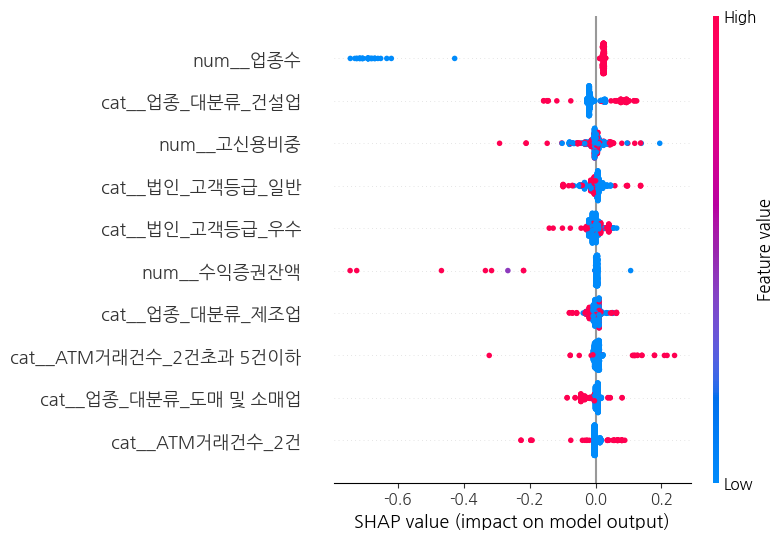

In [28]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore")

# -----------------------------
# 1. Ïú†Í∞ÄÏ¶ùÍ∂å+Ïô∏Ìôò ÏàòÏùµ ÌÉÄÍπÉ Íµ¨ÏÑ±
# -----------------------------
fisis = pd.read_excel("Data/ÏµúÏ¢Ö ÌîÑÎ°úÏ†ùÌä∏/FISIS_MultipleTable_200003-202503.xlsx")

def format_target(df, colname):
    df = df.drop(columns=["ÌöåÏÇ¨Î™Ö", "ÌöåÏÇ¨ÏΩîÎìú", "Î≥¥Í≥†ÏÑúÎ™Ö", "Î≥¥Í≥†ÏÑúÏΩîÎìú", "Ìï≠Î™©", "factor_id", "Îã®ÏúÑ"])
    df = df.T
    df.columns = [colname]
    df.index = pd.to_datetime(df.index, format="%YÎÖÑ%mÏõî")
    return df

sec_income = fisis[(fisis["ÌöåÏÇ¨Î™Ö"] == "ÏïÑÏù¥Ïó†Î±ÖÌÅ¨") & (fisis["Ìï≠Î™©"] == "Ïú†Í∞ÄÏ¶ùÍ∂å ÏÜêÏùµ:ÎãπÎ∂ÑÍ∏∞")]
fx_income = fisis[(fisis["ÌöåÏÇ¨Î™Ö"] == "ÏïÑÏù¥Ïó†Î±ÖÌÅ¨") & (fisis["Ìï≠Î™©"] == "Ïô∏ÌôòÍ¥ÄÎ†® ÏÜêÏùµ:ÎãπÎ∂ÑÍ∏∞")]

sec_df = format_target(sec_income, "Ïú†Í∞ÄÏ¶ùÍ∂åÏàòÏùµ")
fx_df = format_target(fx_income, "Ïô∏ÌôòÏàòÏùµ")

total_df = sec_df.join(fx_df, how="outer").fillna(0)
total_df["Ïú†Í∞ÄÏô∏ÌôòÏàòÏùµ"] = total_df["Ïú†Í∞ÄÏ¶ùÍ∂åÏàòÏùµ"] + total_df["Ïô∏ÌôòÏàòÏùµ"]
total_df = total_df[["Ïú†Í∞ÄÏô∏ÌôòÏàòÏùµ"]].resample("MS").interpolate("linear").reset_index().rename(columns={"index": "Í∏∞Ï§ÄÎÖÑÏõî"})

# -----------------------------
# 2. ÎÇ¥Î∂Ä Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞ Î∞è Î≥ëÌï©
# -----------------------------
df = pd.read_csv("Data/ÏµúÏ¢Ö ÌîÑÎ°úÏ†ùÌä∏/ÏµúÏ¢Ö_Îç∞Ïù¥ÌÑ∞.csv", encoding="cp949")
df["Í∏∞Ï§ÄÎÖÑÏõî"] = pd.to_datetime(df["Í∏∞Ï§ÄÎÖÑÏõî"], format="%Y%m")

merged = pd.merge(df, total_df, on="Í∏∞Ï§ÄÎÖÑÏõî", how="inner").dropna(subset=["Ïú†Í∞ÄÏô∏ÌôòÏàòÏùµ"])
merged["Í≥†Í∞ùÏàò"] = merged.groupby("Í∏∞Ï§ÄÎÖÑÏõî")["Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â"].transform("count")
merged = merged[merged["Í≥†Í∞ùÏàò"] > 0]

merged["Ïú†Í∞ÄÏô∏Ìôò_perÍ≥†Í∞ù"] = merged["Ïú†Í∞ÄÏô∏ÌôòÏàòÏùµ"] / merged["Í≥†Í∞ùÏàò"]
merged = merged[merged["Ïú†Í∞ÄÏô∏Ìôò_perÍ≥†Í∞ù"] > 0].dropna(subset=["Ïú†Í∞ÄÏô∏Ìôò_perÍ≥†Í∞ù"])
y = np.log1p(merged["Ïú†Í∞ÄÏô∏Ìôò_perÍ≥†Í∞ù"])

# -----------------------------
# 3. ÏÑ§Î™ÖÎ≥ÄÏàò Ï†ïÏùò
# -----------------------------
merged["Í≥†Ïã†Ïö©ÎπÑÏ§ë"] = (merged["Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â"] == "ÏµúÏö∞Ïàò").astype(int)
merged["ÏóÖÏ¢ÖÏàò"] = merged.groupby("Í∏∞Ï§ÄÎÖÑÏõî")["ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò"].transform("nunique")

features = [
    "Ïô∏Ìôò_ÏàòÏ∂úÏã§Ï†ÅÍ∏àÏï°", "Ïô∏Ìôò_ÏàòÏûÖÏã§Ï†ÅÍ∏àÏï°", 
    "Ïô∏Ìôò_ÏàòÏ∂úÏã§Ï†ÅÍ±∞ÎûòÍ±¥Ïàò", "Ïô∏Ìôò_ÏàòÏûÖÏã§Ï†ÅÍ±∞ÎûòÍ±¥Ïàò",
    "ÏàòÏùµÏ¶ùÍ∂åÏ¢åÏàò", "ÏàòÏùµÏ¶ùÍ∂åÏûîÏï°", "ATMÍ±∞ÎûòÍ±¥Ïàò",
    "Í≥†Ïã†Ïö©ÎπÑÏ§ë", "ÏóÖÏ¢ÖÏàò",
    "Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â", "ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò"
]
X = merged[features]

# -----------------------------
# 4. SHAPÏö© ÏÉòÌîå Ï∂ïÏÜå
# -----------------------------
X_sample = X.sample(n=500, random_state=42)
y_sample = y.loc[X_sample.index]

# -----------------------------
# 5. Ï†ÑÏ≤òÎ¶¨ Ï†ïÏùò
# -----------------------------
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)  # <- Ïù¥ Î∂ÄÎ∂Ñ ÏàòÏ†ï
])

# -----------------------------
# 6. Î™®Îç∏ ÌïôÏäµ Î∞è SHAP Î∂ÑÏÑù
# -----------------------------
models = {
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=4, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, max_depth=4, random_state=42, force_col_wise=True),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
}

top_features = {}

for name, model in models.items():
    print(f"\n‚ñ∂ Î™®Îç∏: {name}")
    
    pipeline = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])
    
    pipeline.fit(X_sample, y_sample)
    
    X_transformed = preprocessor.fit_transform(X_sample)
    explainer = shap.Explainer(pipeline.named_steps["model"], X_transformed, feature_names=preprocessor.get_feature_names_out(), algorithm="tree")
    shap_values = explainer(X_transformed)

    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    shap_df = pd.DataFrame({
        "Î≥ÄÏàò": preprocessor.get_feature_names_out(),
        "SHAP ÏòÅÌñ•Î†•": mean_abs_shap
    }).sort_values(by="SHAP ÏòÅÌñ•Î†•", ascending=False)

    print(shap_df.head(10))
    top_features[name] = shap_df["Î≥ÄÏàò"].head(10).tolist()

# -----------------------------
# 7. Î≥ÄÏàò ÏùºÏπòÎèÑ ÎπÑÍµê Ï∂úÎ†•
# -----------------------------
print("\nüîç Î™®Îç∏ Í∞Ñ SHAP Top10 Î≥ÄÏàò ÏùºÏπòÎèÑ")

xgb_set = set(top_features["XGBoost"])
lgb_set = set(top_features["LightGBM"])
rf_set = set(top_features["RandomForest"])

# -----------------------------
# 8. ÏÑ∏ Î™®Îç∏ Ï§ë 2Í∞ú Ïù¥ÏÉÅÏóêÏÑú Îì±Ïû•Ìïú Î≥ÄÏàòÎßå ÌïÑÌÑ∞ÎßÅ ÌõÑ summary_plot
# -----------------------------
from collections import Counter

# Î™®Îì† Top10 Î≥ÄÏàò Î™®ÏïÑÏÑú Îì±Ïû• ÌöüÏàò Í≥ÑÏÇ∞
all_top_vars = top_features["XGBoost"] + top_features["LightGBM"] + top_features["RandomForest"]
var_counter = Counter(all_top_vars)

# 2Í∞ú Ïù¥ÏÉÅ Î™®Îç∏Ïóê Îì±Ïû•Ìïú Î≥ÄÏàòÎßå Ï∂îÏ∂ú
shared_vars = [var for var, count in var_counter.items() if count >= 2]

print("\n‚úÖ 2Í∞ú Ïù¥ÏÉÅ Î™®Îç∏Ïóê Í≥µÌÜµ Îì±Ïû•Ìïú Ï£ºÏöî Î≥ÄÏàò:")
print(shared_vars)

# XGBoost Í∏∞Ï§Ä SHAP Í∞íÍ≥º Ï†ÑÏ≤òÎ¶¨Îêú feature matrix
X_transformed = preprocessor.fit_transform(X_sample)
explainer = shap.Explainer(models["XGBoost"], X_transformed, feature_names=preprocessor.get_feature_names_out(), algorithm="tree")
shap_values = explainer(X_transformed)

# Ìï¥Îãπ Î≥ÄÏàòÎßå ÏÑ†ÌÉùÌïòÏó¨ summary_plot Ïã§Ìñâ
all_feature_names = preprocessor.get_feature_names_out()
selected_indices = [i for i, name in enumerate(all_feature_names) if name in shared_vars]

shap.summary_plot(
    shap_values.values[:, selected_indices],
    features=X_transformed[:, selected_indices],
    feature_names=[all_feature_names[i] for i in selected_indices],
    plot_type="dot"
)


# Ïô∏Ìôò

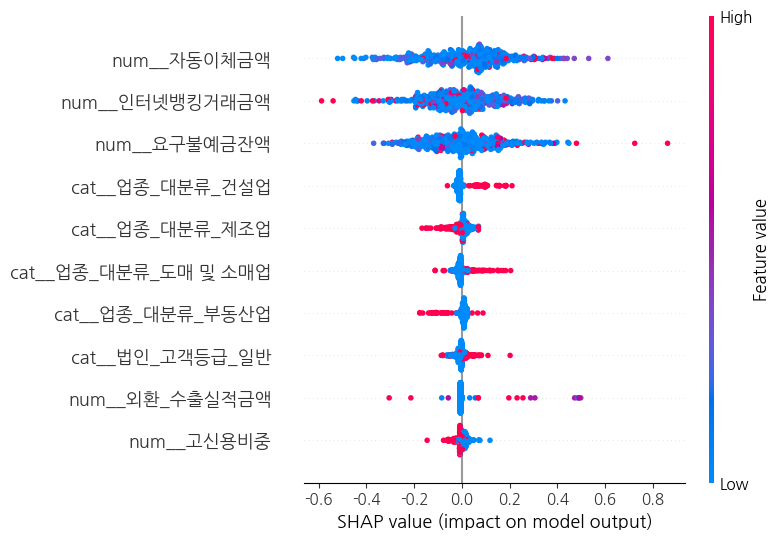

In [9]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

# -----------------------------
# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
# -----------------------------
fisis = pd.read_excel("Data/ÏµúÏ¢Ö ÌîÑÎ°úÏ†ùÌä∏/FISIS_MultipleTable_200003-202503.xlsx")
df = pd.read_csv("Data/ÏµúÏ¢Ö ÌîÑÎ°úÏ†ùÌä∏/ÏµúÏ¢Ö_Îç∞Ïù¥ÌÑ∞.csv", encoding="cp949")
df["Í∏∞Ï§ÄÎÖÑÏõî"] = pd.to_datetime(df["Í∏∞Ï§ÄÎÖÑÏõî"], format="%Y%m")

# -----------------------------
# Ïô∏ÌôòÏàòÏùµ ÌÉÄÍπÉ Íµ¨ÏÑ±
# -----------------------------
def format_target(df, colname):
    df = df.drop(columns=["ÌöåÏÇ¨Î™Ö", "ÌöåÏÇ¨ÏΩîÎìú", "Î≥¥Í≥†ÏÑúÎ™Ö", "Î≥¥Í≥†ÏÑúÏΩîÎìú", "Ìï≠Î™©", "factor_id", "Îã®ÏúÑ"])
    df = df.T
    df.columns = [colname]
    df.index = pd.to_datetime(df.index, format="%YÎÖÑ%mÏõî")
    return df

fx_income = fisis[(fisis["ÌöåÏÇ¨Î™Ö"] == "ÏïÑÏù¥Ïó†Î±ÖÌÅ¨") & (fisis["Ìï≠Î™©"] == "Ïô∏ÌôòÍ¥ÄÎ†® ÏÜêÏùµ:ÎãπÎ∂ÑÍ∏∞")]
fx_df = format_target(fx_income, "Ïô∏ÌôòÏàòÏùµ")
fx_df = fx_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "Í∏∞Ï§ÄÎÖÑÏõî"})

merged_fx = pd.merge(df, fx_df, on="Í∏∞Ï§ÄÎÖÑÏõî", how="inner").dropna(subset=["Ïô∏ÌôòÏàòÏùµ"])
merged_fx["Í≥†Í∞ùÏàò"] = merged_fx.groupby("Í∏∞Ï§ÄÎÖÑÏõî")["Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â"].transform("count")
merged_fx = merged_fx[merged_fx["Í≥†Í∞ùÏàò"] > 0]
merged_fx["Ïô∏Ìôò_perÍ≥†Í∞ù"] = merged_fx["Ïô∏ÌôòÏàòÏùµ"] / merged_fx["Í≥†Í∞ùÏàò"]
merged_fx = merged_fx[merged_fx["Ïô∏Ìôò_perÍ≥†Í∞ù"] > 0].dropna(subset=["Ïô∏Ìôò_perÍ≥†Í∞ù"])
y_fx = np.log1p(merged_fx["Ïô∏Ìôò_perÍ≥†Í∞ù"])

# -----------------------------
# ÏÑ§Î™ÖÎ≥ÄÏàò Ï†ïÏùò
# -----------------------------
merged_fx["Í≥†Ïã†Ïö©ÎπÑÏ§ë"] = (merged_fx["Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â"] == "ÏµúÏö∞Ïàò").astype(int)
merged_fx["ÏóÖÏ¢ÖÏàò"] = merged_fx.groupby("Í∏∞Ï§ÄÎÖÑÏõî")["ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò"].transform("nunique")

X_fx = merged_fx[
    [
        "Ïô∏Ìôò_ÏàòÏ∂úÏã§Ï†ÅÍ∏àÏï°", "Ïô∏Ìôò_ÏàòÏûÖÏã§Ï†ÅÍ∏àÏï°",
        "Ïô∏Ìôò_ÏàòÏ∂úÏã§Ï†ÅÍ±∞ÎûòÍ±¥Ïàò", "Ïô∏Ìôò_ÏàòÏûÖÏã§Ï†ÅÍ±∞ÎûòÍ±¥Ïàò",
        "ÏöîÍµ¨Î∂àÏòàÍ∏àÏûîÏï°", "ÏûêÎèôÏù¥Ï≤¥Í∏àÏï°", "Ïù∏ÌÑ∞ÎÑ∑Î±ÖÌÇπÍ±∞ÎûòÍ∏àÏï°",
        "Í≥†Ïã†Ïö©ÎπÑÏ§ë", "ÏóÖÏ¢ÖÏàò", "Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â", "ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò"
    ]
]

# -----------------------------
# Ï†ÑÏ≤òÎ¶¨ + XGBoost + SHAP
# -----------------------------
X_sample = X_fx.sample(n=500, random_state=42)
y_sample = y_fx.loc[X_sample.index]

num_cols = X_sample.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X_sample.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", XGBRegressor(n_estimators=100, max_depth=4, random_state=42))
])

pipeline.fit(X_sample, y_sample)

X_transformed = preprocessor.fit_transform(X_sample)
explainer = shap.Explainer(
    pipeline.named_steps["model"],
    X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    algorithm="tree"
)
shap_values = explainer(X_transformed)

shap.summary_plot(
    shap_values,
    features=X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    plot_type="dot",
    max_display=10
)

In [13]:
# SHAP ÏòÅÌñ•ÎèÑ ÏàòÏπò ÌôïÏù∏
mean_abs_shap_fx = np.abs(shap_values.values).mean(axis=0)
shap_df_fx = pd.DataFrame({
    "Î≥ÄÏàò": preprocessor.get_feature_names_out(),
    "SHAP ÏòÅÌñ•ÎèÑ": mean_abs_shap_fx
}).sort_values(by="SHAP ÏòÅÌñ•ÎèÑ", ascending=False)

print("üìå Ïô∏ÌôòÏàòÏùµ SHAP ÏòÅÌñ•ÎèÑ Top10")
display(shap_df_fx.head(10))

üìå Ïô∏ÌôòÏàòÏùµ SHAP ÏòÅÌñ•ÎèÑ Top10


Î≥ÄÏàò  SHAP ÏòÅÌñ•ÎèÑ
3            num__ÏûêÎèôÏù¥Ï≤¥Í∏àÏï°  0.130710
4         num__Ïù∏ÌÑ∞ÎÑ∑Î±ÖÌÇπÍ±∞ÎûòÍ∏àÏï°  0.114885
2           num__ÏöîÍµ¨Î∂àÏòàÍ∏àÏûîÏï°  0.111998
10       cat__ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò_Í±¥ÏÑ§ÏóÖ  0.024378
25       cat__ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò_Ï†úÏ°∞ÏóÖ  0.022914
14  cat__ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò_ÎèÑÎß§ Î∞è ÏÜåÎß§ÏóÖ  0.018996
16      cat__ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò_Î∂ÄÎèôÏÇ∞ÏóÖ  0.015567
8        cat__Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â_ÏùºÎ∞ò  0.015424
0         num__Ïô∏Ìôò_ÏàòÏ∂úÏã§Ï†ÅÍ∏àÏï°  0.014311
5             num__Í≥†Ïã†Ïö©ÎπÑÏ§ë  0.013910

# Ïú†Í∞ÄÏ¶ùÍ∂å

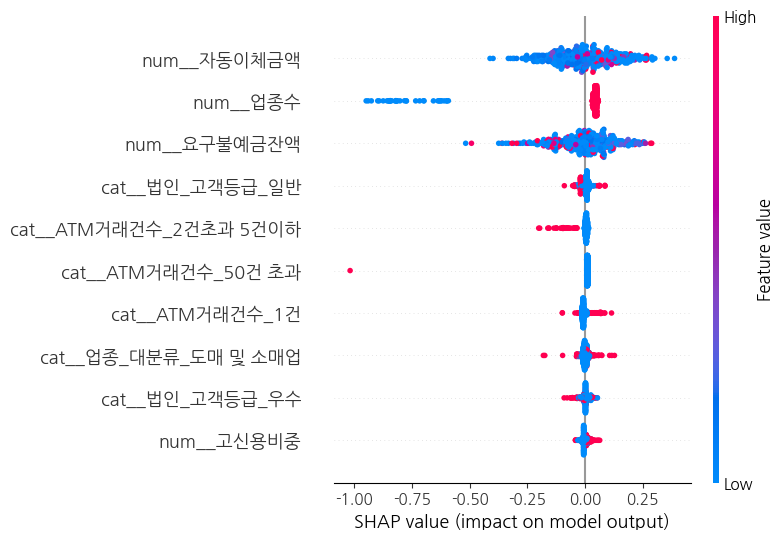

In [15]:
# -----------------------------
# Ïú†Í∞ÄÏ¶ùÍ∂åÏàòÏùµ ÌÉÄÍπÉ Íµ¨ÏÑ±
# -----------------------------
sec_income = fisis[(fisis["ÌöåÏÇ¨Î™Ö"] == "ÏïÑÏù¥Ïó†Î±ÖÌÅ¨") & (fisis["Ìï≠Î™©"] == "Ïú†Í∞ÄÏ¶ùÍ∂å ÏÜêÏùµ:ÎãπÎ∂ÑÍ∏∞")]
sec_df = format_target(sec_income, "Ïú†Í∞ÄÏ¶ùÍ∂åÏàòÏùµ")
sec_df = sec_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "Í∏∞Ï§ÄÎÖÑÏõî"})

merged_sec = pd.merge(df, sec_df, on="Í∏∞Ï§ÄÎÖÑÏõî", how="inner").dropna(subset=["Ïú†Í∞ÄÏ¶ùÍ∂åÏàòÏùµ"])
merged_sec["Í≥†Í∞ùÏàò"] = merged_sec.groupby("Í∏∞Ï§ÄÎÖÑÏõî")["Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â"].transform("count")
merged_sec = merged_sec[merged_sec["Í≥†Í∞ùÏàò"] > 0]
merged_sec["Ïú†Í∞Ä_perÍ≥†Í∞ù"] = merged_sec["Ïú†Í∞ÄÏ¶ùÍ∂åÏàòÏùµ"] / merged_sec["Í≥†Í∞ùÏàò"]
merged_sec = merged_sec[merged_sec["Ïú†Í∞Ä_perÍ≥†Í∞ù"] > 0].dropna(subset=["Ïú†Í∞Ä_perÍ≥†Í∞ù"])
y_sec = np.log1p(merged_sec["Ïú†Í∞Ä_perÍ≥†Í∞ù"])

# -----------------------------
# ÏÑ§Î™ÖÎ≥ÄÏàò Ï†ïÏùò
# -----------------------------
merged_sec["Í≥†Ïã†Ïö©ÎπÑÏ§ë"] = (merged_sec["Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â"] == "ÏµúÏö∞Ïàò").astype(int)
merged_sec["ÏóÖÏ¢ÖÏàò"] = merged_sec.groupby("Í∏∞Ï§ÄÎÖÑÏõî")["ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò"].transform("nunique")

X_sec = merged_sec[
    [
        "ÏàòÏùµÏ¶ùÍ∂åÏûîÏï°", "ÏàòÏùµÏ¶ùÍ∂åÏ¢åÏàò", "ÏöîÍµ¨Î∂àÏòàÍ∏àÏûîÏï°",
        "ÏûêÎèôÏù¥Ï≤¥Í∏àÏï°", "ATMÍ±∞ÎûòÍ±¥Ïàò",
        "Í≥†Ïã†Ïö©ÎπÑÏ§ë", "ÏóÖÏ¢ÖÏàò", "Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â", "ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò"
    ]
]

# -----------------------------
# Ï†ÑÏ≤òÎ¶¨ + XGBoost + SHAP
# -----------------------------
X_sample = X_sec.sample(n=500, random_state=42)
y_sample = y_sec.loc[X_sample.index]

num_cols = X_sample.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X_sample.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", XGBRegressor(n_estimators=100, max_depth=4, random_state=42))
])

pipeline.fit(X_sample, y_sample)

X_transformed = preprocessor.fit_transform(X_sample)
explainer = shap.Explainer(
    pipeline.named_steps["model"],
    X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    algorithm="tree"
)
shap_values = explainer(X_transformed)

shap.summary_plot(
    shap_values,
    features=X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    plot_type="dot",
    max_display=10
)


In [16]:
# SHAP ÏòÅÌñ•ÎèÑ ÏàòÏπò ÌôïÏù∏
mean_abs_shap_sec = np.abs(shap_values.values).mean(axis=0)
shap_df_sec = pd.DataFrame({
    "Î≥ÄÏàò": preprocessor.get_feature_names_out(),
    "SHAP ÏòÅÌñ•ÎèÑ": mean_abs_shap_sec
}).sort_values(by="SHAP ÏòÅÌñ•ÎèÑ", ascending=False)

print("üìå Ïú†Í∞ÄÏ¶ùÍ∂åÏàòÏùµ SHAP ÏòÅÌñ•ÎèÑ Top10")
display(shap_df_sec.head(10))


üìå Ïú†Í∞ÄÏ¶ùÍ∂åÏàòÏùµ SHAP ÏòÅÌñ•ÎèÑ Top10


Î≥ÄÏàò  SHAP ÏòÅÌñ•ÎèÑ
2              num__ÏûêÎèôÏù¥Ï≤¥Í∏àÏï°  0.103808
4                 num__ÏóÖÏ¢ÖÏàò  0.098678
1             num__ÏöîÍµ¨Î∂àÏòàÍ∏àÏûîÏï°  0.090037
6          cat__Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â_ÏùºÎ∞ò  0.014012
34  cat__ATMÍ±∞ÎûòÍ±¥Ïàò_2Í±¥Ï¥àÍ≥º 5Í±¥Ïù¥Ìïò  0.012331
37     cat__ATMÍ±∞ÎûòÍ±¥Ïàò_50Í±¥ Ï¥àÍ≥º  0.012274
31         cat__ATMÍ±∞ÎûòÍ±¥Ïàò_1Í±¥  0.011697
16    cat__ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò_ÎèÑÎß§ Î∞è ÏÜåÎß§ÏóÖ  0.011234
5          cat__Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â_Ïö∞Ïàò  0.010670
3               num__Í≥†Ïã†Ïö©ÎπÑÏ§ë  0.009810

# ÌåêÍ¥ÄÎπÑ

In [2]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor
import lightgbm as lgb 

warnings.filterwarnings("ignore")

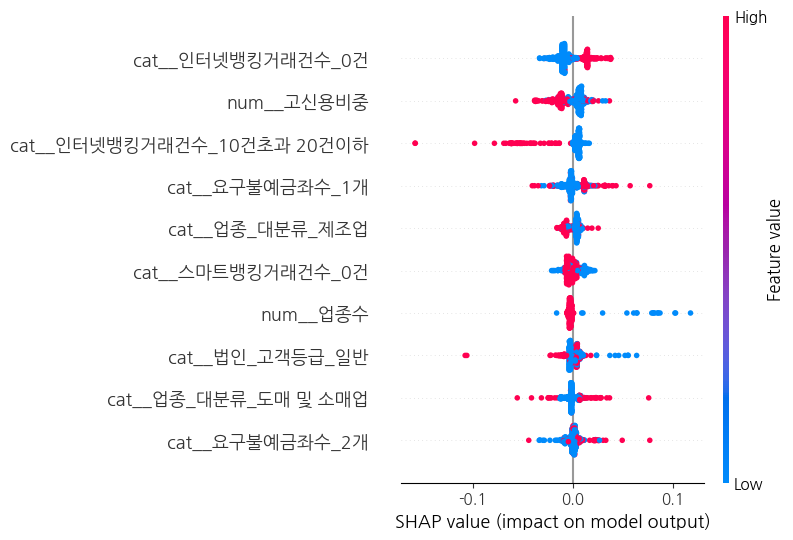

In [17]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

# -----------------------------
# 1. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞ Î∞è Î≥ëÌï©
# -----------------------------
fisis = pd.read_excel("Data/ÏµúÏ¢Ö ÌîÑÎ°úÏ†ùÌä∏/FISIS_MultipleTable_200003-202503.xlsx")
df = pd.read_csv("Data/ÏµúÏ¢Ö ÌîÑÎ°úÏ†ùÌä∏/ÏµúÏ¢Ö_Îç∞Ïù¥ÌÑ∞.csv", encoding="cp949")
df["Í∏∞Ï§ÄÎÖÑÏõî"] = pd.to_datetime(df["Í∏∞Ï§ÄÎÖÑÏõî"], format="%Y%m")

# ÌåêÍ¥ÄÎπÑ Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
target_df = (
    fisis[(fisis["ÌöåÏÇ¨Î™Ö"] == "ÏïÑÏù¥Ïó†Î±ÖÌÅ¨") & (fisis["Ìï≠Î™©"] == "ÌåêÎß§ÎπÑÏôÄ Í¥ÄÎ¶¨ÎπÑ:ÎãπÎ∂ÑÍ∏∞")]
    .drop(columns=["ÌöåÏÇ¨Î™Ö", "ÌöåÏÇ¨ÏΩîÎìú", "Î≥¥Í≥†ÏÑúÎ™Ö", "Î≥¥Í≥†ÏÑúÏΩîÎìú", "Ìï≠Î™©", "factor_id", "Îã®ÏúÑ"])
    .T.rename(columns={fisis[(fisis["ÌöåÏÇ¨Î™Ö"] == "ÏïÑÏù¥Ïó†Î±ÖÌÅ¨") & (fisis["Ìï≠Î™©"] == "ÌåêÎß§ÎπÑÏôÄ Í¥ÄÎ¶¨ÎπÑ:ÎãπÎ∂ÑÍ∏∞")].index[0]: "ÌåêÍ¥ÄÎπÑ"})
)
target_df.index = pd.to_datetime(target_df.index, format="%YÎÖÑ%mÏõî")
target_df = target_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "Í∏∞Ï§ÄÎÖÑÏõî"})

# Î≥ëÌï© Î∞è ÌÉÄÍπÉ Íµ¨ÏÑ±
merged = pd.merge(df, target_df, on="Í∏∞Ï§ÄÎÖÑÏõî", how="inner")
merged["Í≥†Í∞ùÏàò"] = merged.groupby("Í∏∞Ï§ÄÎÖÑÏõî")["Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â"].transform("count")
merged = merged[(merged["Í≥†Í∞ùÏàò"] > 0) & (merged["ÌåêÍ¥ÄÎπÑ"] > 0)]
merged["ÌåêÍ¥ÄÎπÑ_perÍ≥†Í∞ù"] = merged["ÌåêÍ¥ÄÎπÑ"] / merged["Í≥†Í∞ùÏàò"]
merged = merged[merged["ÌåêÍ¥ÄÎπÑ_perÍ≥†Í∞ù"] > 0]
y = np.log1p(merged["ÌåêÍ¥ÄÎπÑ_perÍ≥†Í∞ù"])

# -----------------------------
# 2. ÏÑ§Î™ÖÎ≥ÄÏàò ÏÑ§Ï†ï
# -----------------------------
merged["Í≥†Ïã†Ïö©ÎπÑÏ§ë"] = (merged["Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â"] == "ÏµúÏö∞Ïàò").astype(int)
merged["ÏóÖÏ¢ÖÏàò"] = merged.groupby("Í∏∞Ï§ÄÎÖÑÏõî")["ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò"].transform("nunique")

features = [
    "Ï∞ΩÍµ¨Í±∞ÎûòÍ±¥Ïàò", "Ïù∏ÌÑ∞ÎÑ∑Î±ÖÌÇπÍ±∞ÎûòÍ±¥Ïàò", "Ïä§ÎßàÌä∏Î±ÖÌÇπÍ±∞ÎûòÍ±¥Ïàò",
    "ÏöîÍµ¨Î∂àÏòàÍ∏àÏ¢åÏàò", "Ï†ÅÎ¶ΩÏãùÏòàÍ∏àÏ¢åÏàò", "Í±∞ÏπòÏãùÏòàÍ∏àÏ¢åÏàò",
    "Í≥†Ïã†Ïö©ÎπÑÏ§ë", "ÏóÖÏ¢ÖÏàò",
    "Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â", "ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò"
]
X = merged[features]

# -----------------------------
# 3. Ï†ÑÏ≤òÎ¶¨ Î∞è ÏÉòÌîåÎßÅ
# -----------------------------
X_sample = X.sample(n=500, random_state=42)
y_sample = y.loc[X_sample.index]

num_cols = X_sample.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X_sample.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

# -----------------------------
# 4. XGBoost ÌïôÏäµ Î∞è SHAP Top10 ÏãúÍ∞ÅÌôî
# -----------------------------
pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", XGBRegressor(n_estimators=100, max_depth=4, random_state=42))
])
pipeline.fit(X_sample, y_sample)

X_transformed = preprocessor.fit_transform(X_sample)
feature_names = preprocessor.get_feature_names_out()

explainer = shap.Explainer(
    pipeline.named_steps["model"],
    X_transformed,
    feature_names=feature_names,
    algorithm="tree"
)
shap_values = explainer(X_transformed)

# SHAP ÌèâÍ∑† ÏòÅÌñ•ÎèÑ Í≥ÑÏÇ∞
mean_shap = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    "Î≥ÄÏàò": feature_names,
    "SHAP ÏòÅÌñ•Î†•": mean_shap
}).sort_values(by="SHAP ÏòÅÌñ•Î†•", ascending=False)

# Top10 Î≥ÄÏàò Ïù∏Îç±Ïä§ Ï∂îÏ∂ú
top10_vars = shap_df["Î≥ÄÏàò"].head(10).tolist()
top10_indices = [i for i, name in enumerate(feature_names) if name in top10_vars]

# -----------------------------
# 5. SHAP Summary Plot Ï∂úÎ†•
# -----------------------------
shap.summary_plot(
    shap_values.values[:, top10_indices],
    features=X_transformed[:, top10_indices],
    feature_names=[feature_names[i] for i in top10_indices],
    plot_type="dot"
)

In [20]:
# -----------------------------
# XGBoost Í∏∞Ï§Ä SHAP Top10 ÏòÅÌñ•ÎèÑ ÏàòÏπò ÌôïÏù∏
# -----------------------------

# SHAP ÌèâÍ∑† ÏòÅÌñ•ÎèÑ Í≥ÑÏÇ∞
mean_shap = np.abs(shap_values.values).mean(axis=0)

# SHAP ÏòÅÌñ•ÎèÑ ÌÖåÏù¥Î∏î ÏÉùÏÑ±
shap_df = pd.DataFrame({
    "Î≥ÄÏàò": feature_names,
    "SHAP ÏòÅÌñ•ÎèÑ": mean_shap
}).sort_values(by="SHAP ÏòÅÌñ•ÎèÑ", ascending=False)

# Top10 Ï∂úÎ†•
print("üìå XGBoost Í∏∞Ï§Ä ÌåêÍ¥ÄÎπÑ SHAP ÏòÅÌñ•ÎèÑ Top10")
display(shap_df.head(10))


üìå XGBoost Í∏∞Ï§Ä ÌåêÍ¥ÄÎπÑ SHAP ÏòÅÌñ•ÎèÑ Top10


Î≥ÄÏàò  SHAP ÏòÅÌñ•ÎèÑ
31           cat__Ïù∏ÌÑ∞ÎÑ∑Î±ÖÌÇπÍ±∞ÎûòÍ±¥Ïàò_0Í±¥  0.011820
0                   num__Í≥†Ïã†Ïö©ÎπÑÏ§ë  0.009862
32  cat__Ïù∏ÌÑ∞ÎÑ∑Î±ÖÌÇπÍ±∞ÎûòÍ±¥Ïàò_10Í±¥Ï¥àÍ≥º 20Í±¥Ïù¥Ìïò  0.009601
4              cat__ÏöîÍµ¨Î∂àÏòàÍ∏àÏ¢åÏàò_1Í∞ú  0.007262
61             cat__ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò_Ï†úÏ°∞ÏóÖ  0.005070
11           cat__Ïä§ÎßàÌä∏Î±ÖÌÇπÍ±∞ÎûòÍ±¥Ïàò_0Í±¥  0.005052
1                     num__ÏóÖÏ¢ÖÏàò  0.005045
64             cat__Î≤ïÏù∏_Í≥†Í∞ùÎì±Í∏â_ÏùºÎ∞ò  0.004973
50        cat__ÏóÖÏ¢Ö_ÎåÄÎ∂ÑÎ•ò_ÎèÑÎß§ Î∞è ÏÜåÎß§ÏóÖ  0.004874
6              cat__ÏöîÍµ¨Î∂àÏòàÍ∏àÏ¢åÏàò_2Í∞ú  0.004344

.   
# „Öá„Öá„Öá„Öá